In [5]:
%matplotlib inline

import networkx as nx
import pandas as pd
import numpy as np
import scipy as sp
import scipy as spy
import qgrid
import os
import seaborn as sns

from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from sklearn.model_selection import ParameterGrid
from collections import namedtuple
from matplotlib import pyplot as plt

import itertools
import sys

sys.path.append("../..")
from networkentropy import network_energy as ne, network_energy_gradient as neg, network_utils as nu

## Correlaction between energy gradient and length of the shortest path for all node pairs
### For sythetic networks

#### Define constants

In [6]:
METHODS = ['graph', 'laplacian', 'randic']
DI_METHODS = ['graph', 'directed_laplacian', 'randic']

In [7]:
DATA_PATH = "energy-gradient-centrality-correlations-data/"
if not os.path.exists(DATA_PATH):
    os.mkdir(DATA_PATH)

In [8]:
def normalize_list(lizt):
    s = sum(lizt)
    part = 1/s
    return [e*part for e in lizt]

def sums_helper(length, total_sum):
    if length < 1:
        raise ValueError("Length must be positive")
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(1, total_sum):
            for permutation in sums_helper(length-1,total_sum - value):
                yield (value,) + permutation
                
def sums(factors, total_sum):
    perms = sums_helper(len(factors), total_sum)
    result = []
    for row in perms:
        norm_row = normalize_list([e*f for e, f in zip(row, factors)])
        result.append(norm_row)
    return result

In [9]:
ABG = list(sums([0.475, 0.475, 0.05], 4))

REPEATS_NO = 4

N = 200

P_PARAMS = ParameterGrid({'p': np.linspace(0.05, 0.3, 3)})
ERDOS_PARAMS = ParameterGrid({'p': np.linspace(0.05, 0.3, 3)})
HOLME_KIM_M = ParameterGrid({'m': range(2, 5)})
HOLME_KIM_P = ParameterGrid({'p': np.linspace(0.05, 0.7, 3)})
K_OUT_K = ParameterGrid({'k': range(1, 4)})
K_OUT_A = ParameterGrid({'a': range(1, 6, 2)})
PARAMS_A_B_G = [{'a': a, 'b': b, 'g': g} for a, b, g in ABG]

Gen = namedtuple('Gen', ['generator', 'params'])
NETWORKS_GENERATORS = {
    'Erdos-Renyi': Gen(lambda p: nx.erdos_renyi_graph(n=N, p=p), ERDOS_PARAMS),
    'Watts-Strogatz': Gen(lambda p: nx.watts_strogatz_graph(n=N, k=4, p=p), P_PARAMS),
    'Waxman': Gen(lambda p: nx.waxman_graph(n=N, alpha=0.5 + p, beta=0.1), P_PARAMS),
    'Holme-Kim-p.05': Gen(lambda m: nx.powerlaw_cluster_graph(n=N, m=m, p=.05), HOLME_KIM_M),
    'Holme-Kim-m2': Gen(lambda p: nx.powerlaw_cluster_graph(n=N, m=2, p=p), HOLME_KIM_P),
# directed networks
    'Erdos-Renyi-directed': Gen(lambda p: nx.erdos_renyi_graph(n=N, p=p, directed=True), ERDOS_PARAMS),
    'k-out-k3': Gen(lambda a: nx.DiGraph(nx.random_k_out_graph(n=N, k=3, alpha=a, self_loops=False)), K_OUT_A),
    'k-out-alpha1': Gen(lambda k: nx.DiGraph(nx.random_k_out_graph(n=N, k=k, alpha=1, self_loops=False)), K_OUT_K),
    'scale-free': Gen(lambda a, b, g: nx.DiGraph(nx.scale_free_graph(alpha=a, beta=b, gamma=g, n=N)), PARAMS_A_B_G)
}

In [10]:
CENTRALITIES = {
    'gradient_centrality-relu': lambda g, method: neg.get_energy_gradient_centrality(g, method=method, activation='relu'),
    'gradient_centrality-elu': lambda g, method: neg.get_energy_gradient_centrality(g, method=method, activation='elu'),
}
GRAD_CENTRALITY_RELU, GRAD_CENTRALITY_ELU = CENTRALITIES.keys()

In [12]:
for name, (generator, params) in NETWORKS_GENERATORS.items():
    print(name)
    for i, params_row in enumerate(params):
        print(params_row)

Erdos-Renyi
{'p': 0.05}
{'p': 0.175}
{'p': 0.3}
Watts-Strogatz
{'p': 0.05}
{'p': 0.175}
{'p': 0.3}
Waxman
{'p': 0.05}
{'p': 0.175}
{'p': 0.3}
Holme-Kim-p.05
{'m': 2}
{'m': 3}
{'m': 4}
Holme-Kim-m2
{'p': 0.05}
{'p': 0.37499999999999994}
{'p': 0.7}
Erdos-Renyi-directed
{'p': 0.05}
{'p': 0.175}
{'p': 0.3}
k-out-k2
{'a': 1}
{'a': 3}
{'a': 5}
k-out-alpha1
{'k': 1}
{'k': 2}
{'k': 3}
scale-free
{'a': 0.45238095238095233, 'b': 0.45238095238095233, 'g': 0.09523809523809523}
{'a': 0.3220338983050848, 'b': 0.6440677966101696, 'g': 0.03389830508474577}
{'a': 0.6440677966101696, 'b': 0.3220338983050848, 'g': 0.03389830508474577}


In [87]:
def create_graphs(generators: dict, repeats_num):
    graphs = []
    for name, (generator, params) in tqdm(list(generators.items())):
        for i, params_row in tqdm(list(enumerate(params))):
            for reepat_no in range(repeats_num):
                g = nu.get_largest_connected_component(generator(**params_row))
                row = {**params_row, 'generator': name, 'params_num': i, 'g': g, 'repeat_no': reepat_no,
                       'id': f'{name} {params_row} {reepat_no}'}
                graphs.append(row)
    return pd.DataFrame(graphs)

#### Create synthetic networks

In [88]:
graphs_df = create_graphs(NETWORKS_GENERATORS, REPEATS_NO)

#### Coalculate shortest paths and gradients for the networks

In [89]:
def compute_shortest_paths_and_gradients_for_graph(graph: nx.Graph, additional_attrs: dict, methods):
    shortest_paths = nx.shortest_path(graph)
    decorated_graph = neg.get_graph_with_energy_data(graph, methods, copy=False)
    results = []
    for source, paths in shortest_paths.items():
        for target, path in paths.items():
            length = len(path) - 1
            if length > 0:
                for method in methods:
                    gradient = neg.get_gradient(graph, source, target, method)
                    path_energy = neg.get_path_energy(graph, path, method)
                    row = OrderedDict(additional_attrs)
                    row.update(OrderedDict([('method', method), 
                                            ('source', source), 
                                            ('target', target), 
                                            ('length', length), 
                                            ('gradient', gradient),
                                            ('abs_gradient', np.abs(gradient)),
                                            ('path_energy', path_energy),
                                            ('avg_path_energy', path_energy/len(path)),]))
                    results.append(row)
    return results
    

def compute_shortest_paths_and_gradients_for_synthetic_networks(graphs_df, methods, di_methods):
    print("started")
    results = []
    for _, (p, generator, graph) in tqdm(list(graphs_df.loc[:,['params_num', 'generator', 'g']].iterrows())):
        additional_attrs = OrderedDict([('param', p),
                                        ('generator', generator),])
        if graph.is_directed():
            print("directed")
            methods_to_use = di_methods
        else:
            print("undirected")
            methods_to_use = methods
        results.extend(compute_shortest_paths_and_gradients_for_graph(graph, additional_attrs, methods_to_use))
    return pd.DataFrame(results)

In [90]:
paths_data_df = compute_shortest_paths_and_gradients_for_synthetic_networks(graphs_df, METHODS, DI_METHODS)

started


undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
undirected
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directed
directe

In [91]:
qgrid.show_grid(paths_data_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### Check is data destribution is normal

In [92]:
def draw_qqplot(data):
    qqplot(data, line='s')
    pyplot.show()

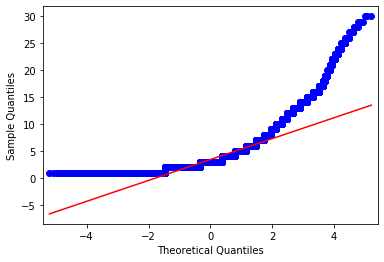

In [93]:
draw_qqplot(paths_data_df.length)

In [94]:
spy.stats.normaltest(paths_data_df.length)

NormaltestResult(statistic=4109021.9630219406, pvalue=0.0)

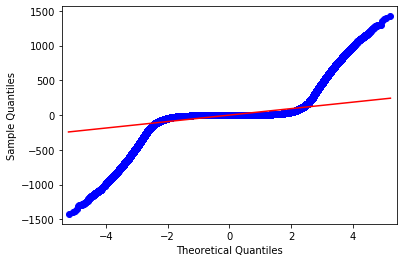

In [95]:
draw_qqplot(paths_data_df.gradient)

In [96]:
spy.stats.normaltest(paths_data_df.gradient)

NormaltestResult(statistic=4296787.877503871, pvalue=0.0)

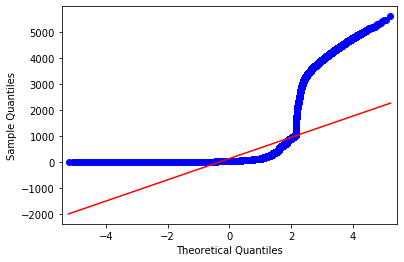

In [97]:
draw_qqplot(paths_data_df.path_energy)

In [98]:
spy.stats.normaltest(paths_data_df.path_energy)

NormaltestResult(statistic=12652251.140719358, pvalue=0.0)

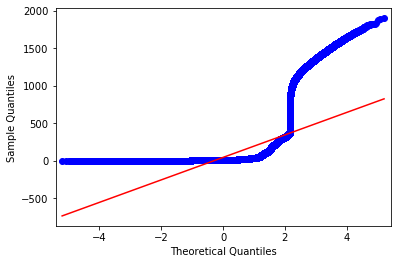

In [99]:
draw_qqplot(paths_data_df.avg_path_energy)

In [100]:
spy.stats.normaltest(paths_data_df.avg_path_energy)

NormaltestResult(statistic=12383268.501354314, pvalue=0.0)

##### Conclusion

Results clearly show the data is not normally distributed for all of the analyzed columns. It is visible on qqplot and also p value of statistical test is zero or very near to zero for all the columns. 

#### Calculate correlations between shortest path lengths and energy gradients

In [101]:
def compute_correlation(grouped_df, column1, column2, methods):
    corr_series = []    
    for method in methods:
        df = grouped_df.corr(method=method)
        index_len = len(df.index.names)
        index_slices = (index_len - 1) * (slice(None),) + (column1,)
        series = df.loc[index_slices, column2]
        series.name = method
        corr_series.append(series)
    corr_df =  pd.concat(corr_series, axis=1)
    corr_df.index = corr_df.index.droplevel(-1)
    return corr_df

def compute_correlation_for_synthetic_networks(paths_gradients_df, column1, column2, methods=['pearson', 'kendall', 'spearman']):
    grouped_df = paths_gradients_df\
                    .query('target > source')\
                    .loc[:, ['method', 'generator', 'param', column1, column2]]\
                    .groupby(['method', 'generator', 'param'])
    return compute_correlation(grouped_df, column1, column2, methods)

In [102]:
pd.options.display.max_rows = 1000

In [103]:
from collections import defaultdict

In [104]:
class ColumnMapDict(defaultdict):
    def __missing__(self, k):
        return k

In [105]:
column_mappings = ColumnMapDict()
column_mappings['directed_laplacian'] = 'laplacian'

unified_paths_data_df = paths_data_df.copy()
unified_paths_data_df['method'] = unified_paths_data_df['method'].apply(lambda m: column_mappings[m])

In [122]:
unified_paths_data_df

,param,generator,method,source,target,length,gradient,abs_gradient,path_energy,avg_path_energy
0,0,Erdos-Renyi,graph,0,55,1,1.722395,1.722395,15.868914,7.934457
1,0,Erdos-Renyi,laplacian,0,55,1,10.000000,10.000000,38.000000,19.000000
2,0,Erdos-Renyi,randic,0,55,1,0.088840,0.088840,5.680034,2.840017
3,0,Erdos-Renyi,graph,0,122,1,6.417401,6.417401,20.563920,10.281960
4,0,Erdos-Renyi,laplacian,0,122,1,17.628427,17.628427,45.628427,22.814214
...,...,...,...,...,...,...,...,...,...,...
10421404,2,scale-free,laplacian,199,42,4,-1.000000,1.000000,37.000000,7.400000
10421405,2,scale-free,randic,199,42,4,0.666667,0.666667,3.337194,0.667439
10421406,2,scale-free,graph,199,31,4,-1.000000,1.000000,8.782036,1.756407
10421407,2,scale-free,laplacian,199,31,4,-2.000000,2.000000,37.000000,7.400000


### Visualizattion of dependence of gradients and lengths

In [227]:
FILE_NAME_SCATTER_TEMPL = "scatter_graph_param0_lengths_{}_{}.png"
FILE_NAME_DIST_TEMPL = "distplot_graph_param0_lengths_{}_{}.png"

In [262]:
sns.set(font_scale=2)

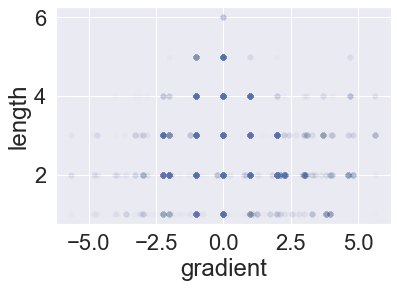

In [275]:
p = sns.scatterplot(data=unified_paths_data_df.query("generator == 'scale-free' and method == 'graph' and param == 0"),
               x='gradient', y='length', alpha=0.01, x_jitter=5)
p.figure.savefig(FILE_NAME_SCATTER_TEMPL.format('gradients', 'scale_free'), bbox_inches="tight")

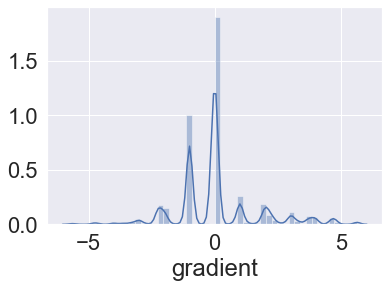

In [276]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'scale-free' and method == 'graph' and param == 0")['gradient'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('gradients', 'scale_free'), bbox_inches="tight")

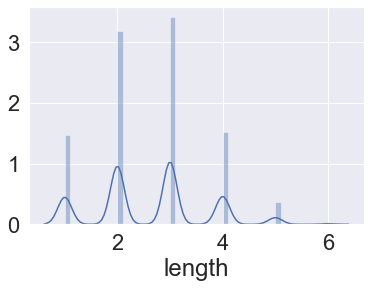

In [289]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'scale-free' and method == 'graph' and param == 0")['length'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('lengths', 'scale_free'), bbox_inches="tight")

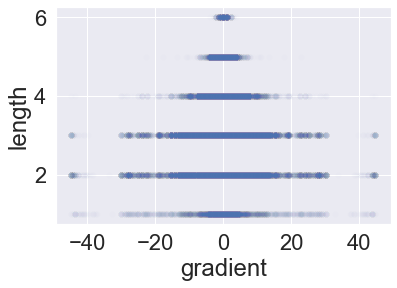

In [277]:
p = sns.scatterplot(data=unified_paths_data_df.query("generator == 'Holme-Kim-p.05' and method == 'graph' and param == 0"),
               x='gradient', y='length', alpha=0.01)
p.figure.savefig(FILE_NAME_SCATTER_TEMPL.format('gradients', 'Holme-Kim-p-05'), bbox_inches="tight")

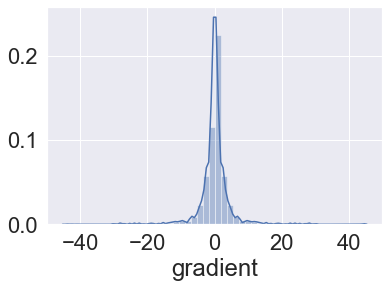

In [278]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'Holme-Kim-p.05' and method == 'graph' and param == 0")['gradient'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('gradients', 'Holme-Kim-p-05'), bbox_inches="tight")

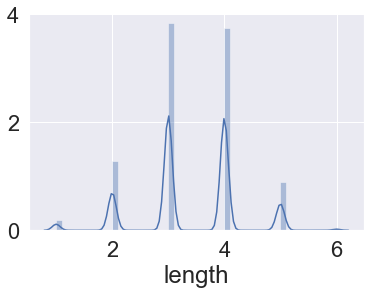

In [290]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'Holme-Kim-p.05' and method == 'graph' and param == 0")['length'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('lengths', 'Holme-Kim-p-05'), bbox_inches="tight")

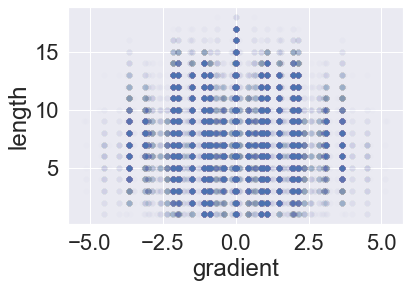

In [279]:
p = sns.scatterplot(data=unified_paths_data_df.query("generator == 'Watts-Strogatz' and method == 'graph' and param == 0"),
               x='gradient', y='length', alpha=0.01)
p.figure.savefig(FILE_NAME_SCATTER_TEMPL.format('gradients', 'Watts-Strogatz'), bbox_inches="tight")

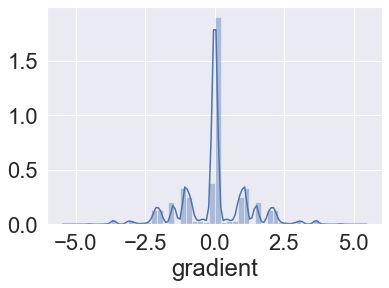

In [280]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'Watts-Strogatz' and method == 'graph' and param == 0")['gradient'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('gradients', 'Watts-Strogatz'), bbox_inches="tight")

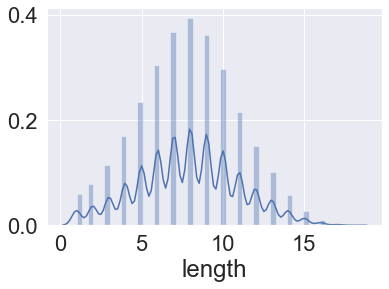

In [291]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'Watts-Strogatz' and method == 'graph' and param == 0")['length'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('lengths', 'Watts-Strogatz'), bbox_inches="tight")

### Visualization of dependece of apth lengs and average path energies

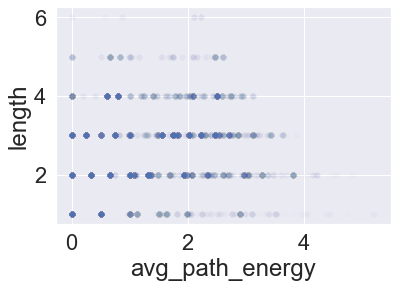

In [281]:
p = sns.scatterplot(data=unified_paths_data_df.query("generator == 'scale-free' and method == 'graph' and param == 0"),
               x='avg_path_energy', y='length', alpha=0.01, x_jitter=5)
p.figure.savefig(FILE_NAME_SCATTER_TEMPL.format('avg_path_energy', 'scale_free'), bbox_inches="tight")

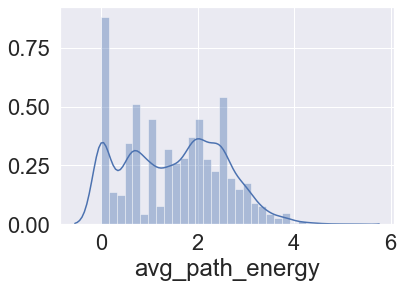

In [286]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'scale-free' and method == 'graph' and param == 0")['avg_path_energy'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('avg_path_energy', 'scale_free'), bbox_inches="tight")

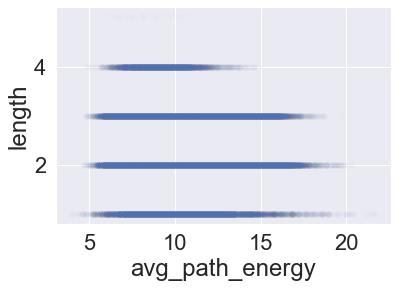

In [282]:
p = sns.scatterplot(data=unified_paths_data_df.query("generator == 'Waxman' and method == 'graph' and param == 0"),
               x='avg_path_energy', y='length', alpha=0.01, x_jitter=5)
p.figure.savefig(FILE_NAME_SCATTER_TEMPL.format('avg_path_energy', 'Waxman'), bbox_inches="tight")

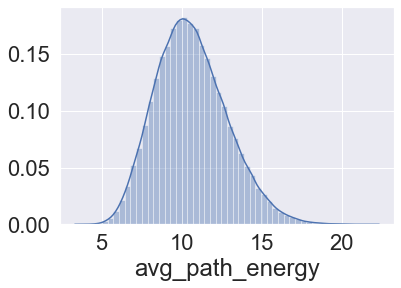

In [283]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'Waxman' and method == 'graph' and param == 0")['avg_path_energy'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('avg_path_energy', 'Waxman'), bbox_inches="tight")

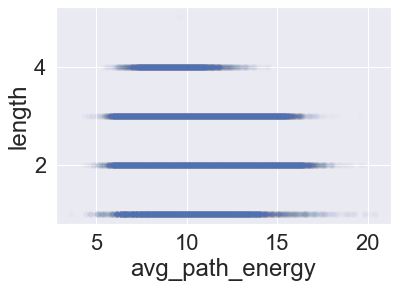

In [284]:
p = sns.scatterplot(data=unified_paths_data_df.query("generator == 'Erdos-Renyi' and method == 'graph' and param == 0"),
               x='avg_path_energy', y='length', alpha=0.01, x_jitter=5)
p.figure.savefig(FILE_NAME_SCATTER_TEMPL.format('avg_path_energy', 'Erdos-Renyi'), bbox_inches="tight")

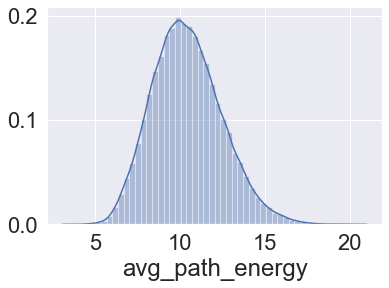

In [285]:
p = sns.distplot(a=unified_paths_data_df.query("generator == 'Erdos-Renyi' and method == 'graph' and param == 0")['avg_path_energy'])
p.figure.savefig(FILE_NAME_DIST_TEMPL.format('avg_path_energy', 'Erdos-Renyi'), bbox_inches="tight")

In [108]:
help(sns.scatterplot)

Help on function scatterplot in module seaborn.relational:

scatterplot(x=None, y=None, hue=None, style=None, size=None, data=None, palette=None, hue_order=None, hue_norm=None, sizes=None, size_order=None, size_norm=None, markers=True, style_order=None, x_bins=None, y_bins=None, units=None, estimator=None, ci=95, n_boot=1000, alpha='auto', x_jitter=None, y_jitter=None, legend='brief', ax=None, **kwargs)
    Draw a scatter plot with possibility of several semantic groupings.
    
    The relationship between ``x`` and ``y`` can be shown for different subsets
    of the data using the ``hue``, ``size``, and ``style`` parameters. These
    parameters control what visual semantics are used to identify the different
    subsets. It is possible to show up to three dimensions independently by
    using all three semantic types, but this style of plot can be hard to
    interpret and is often ineffective. Using redundant semantics (i.e. both
    ``hue`` and ``style`` for the same variable) can

In [152]:
length_abs_gradient_corr_df = compute_correlation_for_synthetic_networks(unified_paths_data_df, 'length', 'abs_gradient')

In [153]:
length_abs_gradient_corr_df.groupby(['generator', 'method']).mean()

pearson   kendall  spearman
generator            method                                 
Erdos-Renyi          graph     -0.009207 -0.007124 -0.008891
                     laplacian -0.003698 -0.003214 -0.003960
                     randic    -0.021371 -0.018066 -0.022558
Erdos-Renyi-directed graph     -0.014284 -0.012714 -0.015012
                     laplacian -0.009071 -0.006939 -0.008676
                     randic    -0.010506 -0.010211 -0.012492
Holme-Kim-m2         graph     -0.308751 -0.222524 -0.284956
                     laplacian -0.311171 -0.236398 -0.304338
                     randic    -0.304356 -0.222490 -0.282811
Holme-Kim-p.05       graph     -0.319965 -0.246807 -0.312155
                     laplacian -0.331950 -0.265866 -0.336871
                     randic    -0.312851 -0.233792 -0.293374
Watts-Strogatz       graph     -0.054106 -0.046306 -0.063691
                     laplacian -0.090572 -0.071019 -0.097293
                     randic    -0.072622 -0.063144 -0.086417
Waxman               graph     -0.034007 -0.024246 -0.030515
                     laplacian -0.022842 -0.016081 -0.020228
                     randic    -0.040206 -0.032944 -0.041455
k-out-alpha1         graph     -0.045388 -0.041748 -0.047850
                     laplacian  0.011753  0.014776  0.017259
                     randic    -0.045388 -0.041748 -0.047850
k-out-k2             graph     -0.059746 -0.057095 -0.064759
                     laplacian -0.017983 -0.013666 -0.016195
                     randic    -0.060401 -0.057382 -0.065342
scale-free           graph     -0.364716 -0.320605 -0.380179
                     laplacian -0.428765 -0.371630 -0.460718
                     randic    -0.258014 -0.231971 -0.286928

In [154]:
path_energy_length_corr_df = compute_correlation_for_synthetic_networks(unified_paths_data_df, 'length', 'path_energy')

In [155]:
path_energy_length_corr_df.groupby(['generator', 'method']).mean()

pearson   kendall  spearman
generator            method                                 
Erdos-Renyi          graph      0.741151  0.554639  0.678788
                     laplacian  0.757539  0.566108  0.692032
                     randic     0.861585  0.579194  0.707253
Erdos-Renyi-directed graph      0.599312  0.444525  0.544736
                     laplacian  0.661624  0.524177  0.641693
                     randic     0.709748  0.454740  0.558296
Holme-Kim-m2         graph      0.524675  0.393379  0.499665
                     laplacian  0.456340  0.338853  0.434285
                     randic     0.616438  0.470041  0.588754
Holme-Kim-p.05       graph      0.371349  0.285566  0.362052
                     laplacian  0.331672  0.253610  0.322727
                     randic     0.495533  0.377836  0.473514
Watts-Strogatz       graph      0.943424  0.840938  0.935203
                     laplacian  0.942066  0.837825  0.932831
                     randic     0.979090  0.900980  0.973420
Waxman               graph      0.577154  0.464892  0.568221
                     laplacian  0.619830  0.501861  0.611052
                     randic     0.648322  0.523830  0.636411
k-out-alpha1         graph      0.078262  0.068571  0.079715
                     laplacian  0.983135  0.939855  0.978379
                     randic     0.078262  0.068571  0.079715
k-out-k2             graph      0.089762  0.070861  0.081836
                     laplacian  0.971482  0.903690  0.964740
                     randic     0.090494  0.070541  0.081742
scale-free           graph      0.670798  0.547874  0.669473
                     laplacian  0.621823  0.494461  0.619073
                     randic     0.697830  0.558898  0.683049

In [158]:
avg_path_energy_length_corr_df = compute_correlation_for_synthetic_networks(unified_paths_data_df, 'length', 'avg_path_energy')

In [159]:
avg_path_energy_length_corr_df.groupby(['generator', 'method']).mean()

pearson   kendall  spearman
generator            method                                 
Erdos-Renyi          graph     -0.084273 -0.058865 -0.072775
                     laplacian -0.089846 -0.064413 -0.079659
                     randic    -0.072802 -0.055396 -0.068473
Erdos-Renyi-directed graph     -0.027214 -0.018144 -0.021850
                     laplacian -0.033899 -0.021418 -0.026563
                     randic    -0.023959 -0.016293 -0.019871
Holme-Kim-m2         graph      0.005228  0.000471  0.004588
                     laplacian  0.002323 -0.001188  0.002151
                     randic     0.001687 -0.001888  0.002288
Holme-Kim-p.05       graph     -0.031815 -0.005454 -0.004515
                     laplacian -0.031273 -0.009147 -0.008892
                     randic    -0.027897 -0.006441 -0.005536
Watts-Strogatz       graph      0.031695  0.013898  0.015444
                     laplacian -0.006193 -0.010066 -0.009582
                     randic     0.016331  0.009052  0.014562
Waxman               graph     -0.110204 -0.081179 -0.101302
                     laplacian -0.128510 -0.099654 -0.124223
                     randic    -0.102582 -0.077255 -0.096422
k-out-alpha1         graph     -0.034331  0.033105  0.047013
                     laplacian -0.048288 -0.027744 -0.018994
                     randic    -0.034331  0.033102  0.047010
k-out-k2             graph     -0.046480  0.019656  0.032218
                     laplacian -0.063086 -0.037260 -0.025934
                     randic    -0.046050  0.020650  0.032705
scale-free           graph      0.139171  0.103015  0.138882
                     laplacian  0.033121  0.022230  0.036792
                     randic     0.159043  0.135877  0.179359

In [160]:
pearson_length_abs_gradient_corr_df = length_abs_gradient_corr_df.groupby(['generator', 'method']).mean().loc[:, 'pearson']

In [161]:
pearson_avg_path_energy_length_corr_df = avg_path_energy_length_corr_df.groupby(['generator', 'method']).mean().loc[:, 'pearson']

In [162]:
synthetic_corr = pd.concat([pearson_length_abs_gradient_corr_df, pearson_avg_path_energy_length_corr_df], axis=1)

In [163]:
synthetic_corr.columns = ['gradient', 'average_energy']
synthetic_corr = synthetic_corr.assign(abs_gradient=synthetic_corr['gradient'].apply(lambda e: np.abs(e)))
synthetic_corr = synthetic_corr.assign(abs_average_energy=synthetic_corr['average_energy'].apply(lambda e: np.abs(e)))

In [287]:
synthetic_corr.sort_values('abs_gradient', ascending=False).loc[:,  ['gradient']]

gradient
generator            method             
scale-free           laplacian -0.428765
                     graph     -0.364716
Holme-Kim-p.05       laplacian -0.331950
                     graph     -0.319965
                     randic    -0.312851
Holme-Kim-m2         laplacian -0.311171
                     graph     -0.308751
                     randic    -0.304356
scale-free           randic    -0.258014
Watts-Strogatz       laplacian -0.090572
                     randic    -0.072622
k-out-k2             randic    -0.060401
                     graph     -0.059746
Watts-Strogatz       graph     -0.054106
k-out-alpha1         randic    -0.045388
                     graph     -0.045388
Waxman               randic    -0.040206
                     graph     -0.034007
                     laplacian -0.022842
Erdos-Renyi          randic    -0.021371
k-out-k2             laplacian -0.017983
Erdos-Renyi-directed graph     -0.014284
k-out-alpha1         laplacian  0.011753
Erdos-Renyi-directed randic    -0.010506
Erdos-Renyi          graph     -0.009207
Erdos-Renyi-directed laplacian -0.009071
Erdos-Renyi          laplacian -0.003698

In [165]:
synthetic_corr.sort_values('abs_average_energy', ascending=False).head(12).loc[:, ['average_energy']]

average_energy
generator    method                   
scale-free   randic           0.159043
             graph            0.139171
Waxman       laplacian       -0.128510
             graph           -0.110204
             randic          -0.102582
Erdos-Renyi  laplacian       -0.089846
             graph           -0.084273
             randic          -0.072802
k-out-k2     laplacian       -0.063086
k-out-alpha1 laplacian       -0.048288
k-out-k2     graph           -0.046480
             randic          -0.046050

In [166]:
import codecs
with codecs.open("synthetic_gradient_paths_corr_table.txt", "w", "utf-8") as f:
    f.write(synthetic_corr.sort_values('abs_gradient', ascending=False).head(12).loc[:,  ['gradient']]\
            .to_latex(longtable=True, multirow=True, multicolumn=True))

In [167]:
import codecs
with codecs.open("synthetic_avg_energy_paths_corr_table.txt", "w", "utf-8") as f:
    f.write(synthetic_corr.sort_values('abs_average_energy', ascending=False).head(12).loc[:, ['average_energy']]\
            .to_latex(longtable=True, multirow=True, multicolumn=True))

##### Conclusion

We can observe small correlation for gradient and average path energy, however its maximum values are about -0.35.
There is a very high correlation between path energy and length of the shortest path but these measures are dependent as sum for longer element has more elements so this probably doesn't bring much information.

### For empirical networks

In [13]:
MAX_SIZE = 1000
datasets = nu.create_datasets('konect.uni')\
.filter(min_size=50, max_size=MAX_SIZE + 500)\
.download_and_build_networks('data/')\
.map_to_largest_component()

In [14]:
networks_df = datasets.download_and_build_networks('data/')

In [15]:
networks_df = datasets.to_df().query("real_N <= @MAX_SIZE")

In [ ]:
networks_df

In [26]:
def compute_shortest_paths_and_gradients_for_empirical_networks(networks_df: pd.DataFrame, methods, di_methods):
    results = []
    for _, (name, category, graph) in tqdm(list(networks_df.loc[:, ['name', 'category', 'graph']].iterrows())):
        print(name)
        additional_attrs = OrderedDict([('name', name),                                        
                                        ('category', category),])
        if graph.is_directed():
            print("directed")
            methods_to_use = di_methods
        else:
            print("undirected")
            methods_to_use = methods
        results.extend(compute_shortest_paths_and_gradients_for_graph(graph, additional_attrs, methods_to_use))
    return pd.DataFrame(results)

In [27]:
paths_data_empirical_df = compute_shortest_paths_and_gradients_for_empirical_networks(networks_df, METHODS, DI_METHODS)

brunson_revolution
undirected
arenas-meta
undirected
tntp-ChicagoRegional
undirected
moreno_crime
undirected
adjnoun_adjacency
undirected
dolphins
undirected
moreno_highschool
directed
arenas-jazz
undirected
moreno_lesmis
undirected
maayan-foodweb
directed
moreno_mac
directed
maayan-pdzbase
undirected
moreno_innovation
directed
moreno_oz
directed
moreno_train
undirected
unicodelang
undirected



In [28]:
paths_data_empirical_df.head()

,name,category,method,source,target,length,gradient,abs_gradient,path_energy,avg_path_energy
0,brunson_revolution,Affiliation,graph,1,2,1,-11.847054,11.847054,41.850103,20.925052
1,brunson_revolution,Affiliation,laplacian,1,2,1,-102.239354,102.239354,198.054556,99.027278
2,brunson_revolution,Affiliation,randic,1,2,1,-1.103743,1.103743,7.903992,3.951996
3,brunson_revolution,Affiliation,graph,1,3,1,-7.209050,7.209050,46.488107,23.244053
4,brunson_revolution,Affiliation,laplacian,1,3,1,-81.782711,81.782711,218.511199,109.255600


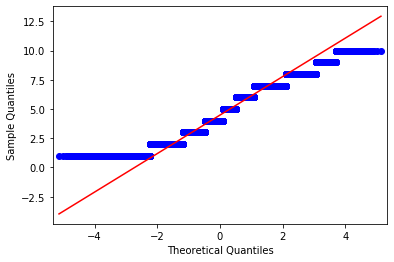

In [29]:
draw_qqplot(paths_data_empirical_df.length)

#### Calculate it again using custom function

It is redundant repetition but I leave it for now

In [30]:
spy.stats.normaltest(paths_data_empirical_df.length)

NormaltestResult(statistic=877081.6869547482, pvalue=0.0)

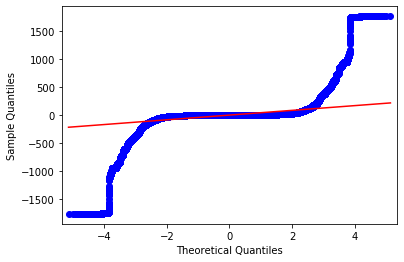

In [31]:
draw_qqplot(paths_data_empirical_df.gradient)

In [32]:
spy.stats.normaltest(paths_data_empirical_df.gradient)

NormaltestResult(statistic=3570457.4098838987, pvalue=0.0)

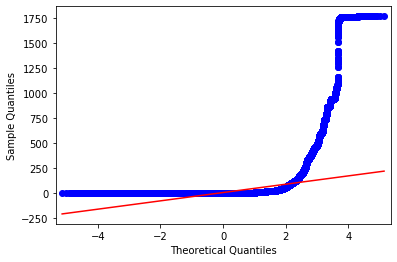

In [33]:
draw_qqplot(paths_data_empirical_df.abs_gradient)

In [34]:
spy.stats.normaltest(paths_data_empirical_df.abs_gradient)

NormaltestResult(statistic=15163303.921459498, pvalue=0.0)

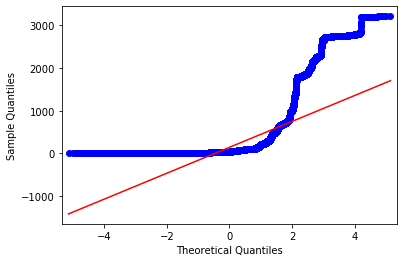

In [35]:
draw_qqplot(paths_data_empirical_df.path_energy)

In [36]:
spy.stats.normaltest(paths_data_empirical_df.path_energy)

NormaltestResult(statistic=6668695.222896375, pvalue=0.0)

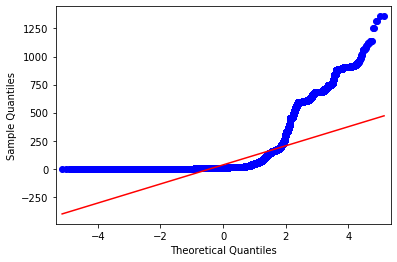

In [37]:
draw_qqplot(paths_data_empirical_df.avg_path_energy)

In [38]:
spy.stats.normaltest(paths_data_empirical_df.avg_path_energy)

NormaltestResult(statistic=6976207.8625119105, pvalue=0.0)

In [59]:
def compute_correlation_for_empirical_networks(paths_gradients_df, column1, column2, methods=['pearson', 'kendall', 'spearman']):
    grouped_df = paths_gradients_df\
                    .query('target > source')\
                    .loc[:, ['category', 'name', 'method', column1, column2,]]\
                    .groupby(['name', 'category', 'method',])
    return compute_correlation(grouped_df, column1, column2, methods)

In [60]:
column_mappings = ColumnMapDict()
column_mappings['directed_laplacian'] = 'laplacian'

emp_unified_paths_data_df = paths_data_empirical_df.copy()
emp_unified_paths_data_df['method'] = emp_unified_paths_data_df['method'].apply(lambda m: column_mappings[m])

In [61]:
length_abs_gradient_corr_empirical_df = \
compute_correlation_for_empirical_networks(emp_unified_paths_data_df,  'length', 'abs_gradient')
qgrid.show_grid(length_abs_gradient_corr_empirical_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [62]:
length_path_energy_corr_empirical_df = \
compute_correlation_for_empirical_networks(emp_unified_paths_data_df,  'length', 'path_energy')
qgrid.show_grid(length_path_energy_corr_empirical_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [63]:
length_avg_path_energy_corr_empirical_df = \
compute_correlation_for_empirical_networks(emp_unified_paths_data_df,  'length', 'avg_path_energy')
qgrid.show_grid(length_avg_path_energy_corr_empirical_df)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [64]:
empirical_corr = pd.concat([length_abs_gradient_corr_empirical_df.loc[:,'pearson'], 
                            length_avg_path_energy_corr_empirical_df.loc[:, 'pearson']], 
                            axis=1)

In [65]:
empirical_corr.columns = ['gradient', 'average_energy']
empirical_corr = empirical_corr.assign(abs_gradient=empirical_corr['gradient'].apply(lambda e: np.abs(e)))
empirical_corr = empirical_corr.assign(abs_average_energy=empirical_corr['average_energy'].apply(lambda e: np.abs(e)))

In [66]:
empirical_corr.sort_values('abs_gradient', ascending=False).loc[:, ['gradient']].head(12)

gradient
name                 category       method             
moreno_lesmis        Misc           randic    -0.376599
moreno_train         HumanContact   randic    -0.362176
unicodelang          Feature        randic    -0.358537
                                    graph     -0.344980
moreno_lesmis        Misc           laplacian -0.342352
unicodelang          Feature        laplacian -0.338274
tntp-ChicagoRegional Infrastructure graph     -0.329637
                                    laplacian -0.329427
brunson_revolution   Affiliation    graph     -0.328406
moreno_train         HumanContact   laplacian -0.321919
brunson_revolution   Affiliation    laplacian -0.317617
adjnoun_adjacency    Lexical        laplacian -0.276223

In [67]:
empirical_corr.sort_values('abs_average_energy', ascending=False).loc[:, ['average_energy']].head(12)

average_energy
name                 category       method                   
brunson_revolution   Affiliation    randic           0.489119
                                    graph            0.483831
                                    laplacian        0.381637
maayan-foodweb       Trophic        laplacian       -0.303279
arenas-meta          Metabolic      graph           -0.221601
                                    laplacian       -0.215628
tntp-ChicagoRegional Infrastructure graph            0.210168
arenas-meta          Metabolic      randic          -0.209411
adjnoun_adjacency    Lexical        randic          -0.207630
dolphins             Animal         graph           -0.204565
moreno_crime         Interaction    graph           -0.194700
                                    laplacian       -0.179621

In [74]:
import codecs
with codecs.open("empirical_avg_energy_paths_corr_table.txt", "w", "utf-8") as f:
    f.write(empirical_corr.sort_values('abs_average_energy', ascending=False).loc[:, ['average_energy']].reset_index()\
            .to_latex(longtable=True, multirow=False, multicolumn=False, index=False))

In [75]:
import codecs
with codecs.open("empirical_gradient_paths_corr_table.txt", "w", "utf-8") as f:
    f.write(empirical_corr.sort_values('abs_gradient', ascending=False).loc[:, ['gradient']].reset_index()\
            .to_latex(longtable=True, multirow=False, multicolumn=False, index=False))

In [357]:
FILE_NAME_SCATTER_TEMPL = "empirical_scatter_graph_param0_lengths_{}_{}.png"
FILE_NAME_DIST_TEMPL = "empirical_distplot_graph_param0_lengths_{}_{}.png"

sns.set(font_scale=2)

def draw_scatterplot(df, name, method, col):
    p = sns.scatterplot(data=df.query("name == @name and method == @method"),
               x=col, y='length', alpha=0.01)
    file_name = FILE_NAME_SCATTER_TEMPL.format(col, name)
    print(file_name)
    p.figure.savefig(file_name, bbox_inches="tight")
    plt.show()
    
def draw_distplot(df, name, method, col):
    p = sns.distplot(a=df.query("name == @name and method == @method")[col])
    file_name = FILE_NAME_DIST_TEMPL.format(col, name)
    print(file_name)
    p.figure.savefig(file_name, bbox_inches="tight")
    plt.show()
    
def draw_plots(df, name, method, col):
    draw_scatterplot(df, name, method, col)
    draw_distplot(df, name, method, col)

In [358]:
emp_unified_paths_data_df

,name,category,method,source,target,length,gradient,abs_gradient,path_energy,avg_path_energy
0,brunson_revolution,Affiliation,graph,1,2,1,-11.847054,11.847054,41.850103,20.925052
1,brunson_revolution,Affiliation,laplacian,1,2,1,-102.239354,102.239354,198.054556,99.027278
2,brunson_revolution,Affiliation,randic,1,2,1,-1.103743,1.103743,7.903992,3.951996
3,brunson_revolution,Affiliation,graph,1,3,1,-7.209050,7.209050,46.488107,23.244053
4,brunson_revolution,Affiliation,laplacian,1,3,1,-81.782711,81.782711,218.511199,109.255600
...,...,...,...,...,...,...,...,...,...,...
7203874,unicodelang,Feature,laplacian,435,393,5,0.000000,0.000000,438.878743,73.146457
7203875,unicodelang,Feature,randic,435,393,5,0.000000,0.000000,35.950454,5.991742
7203876,unicodelang,Feature,graph,435,571,5,0.000000,0.000000,63.587031,10.597839
7203877,unicodelang,Feature,laplacian,435,571,5,0.000000,0.000000,190.216037,31.702673


empirical_scatter_graph_param0_lengths_gradient_moreno_lesmis.png


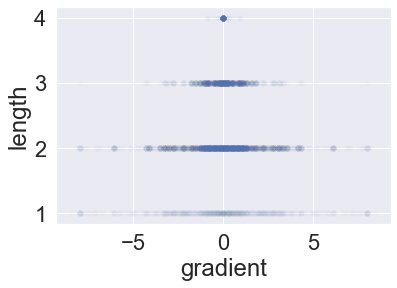

empirical_distplot_graph_param0_lengths_gradient_moreno_lesmis.png


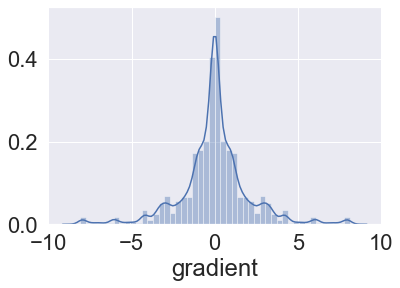

empirical_scatter_graph_param0_lengths_gradient_moreno_train.png


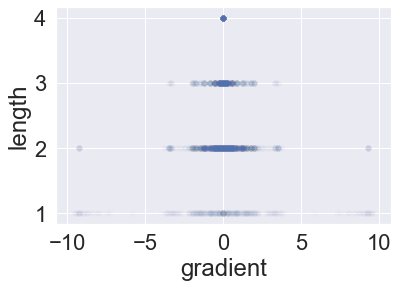

empirical_distplot_graph_param0_lengths_gradient_moreno_train.png


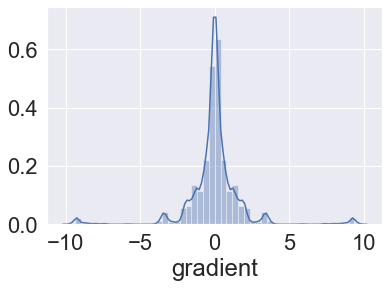

empirical_scatter_graph_param0_lengths_gradient_unicodelang.png


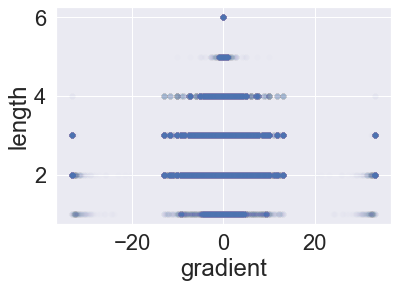

empirical_distplot_graph_param0_lengths_gradient_unicodelang.png


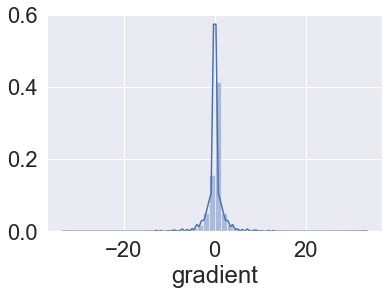

In [359]:
for _, (name, method) in empirical_corr.sort_values('abs_gradient', ascending=False)\
                                  .loc[:, ['gradient']].head(3).reset_index().loc[:,['name','method']].iterrows():
    draw_plots(emp_unified_paths_data_df, name, method, 'gradient')

empirical_scatter_graph_param0_lengths_avg_path_energy_brunson_revolution.png


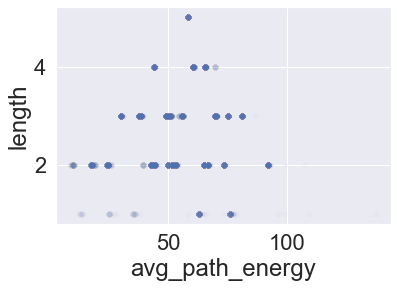

empirical_distplot_graph_param0_lengths_avg_path_energy_brunson_revolution.png


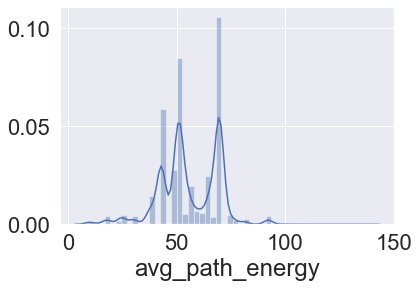

empirical_scatter_graph_param0_lengths_avg_path_energy_maayan-foodweb.png


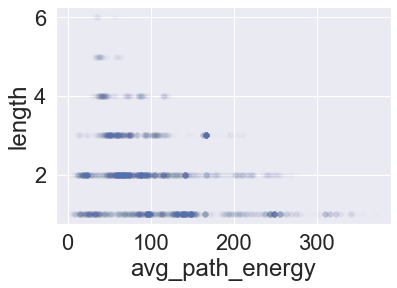

empirical_distplot_graph_param0_lengths_avg_path_energy_maayan-foodweb.png


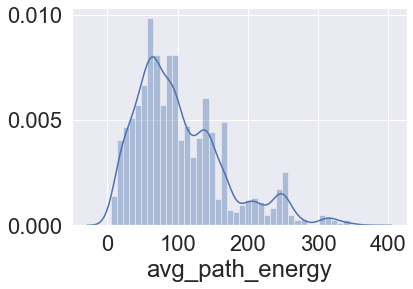

empirical_scatter_graph_param0_lengths_avg_path_energy_arenas-meta.png


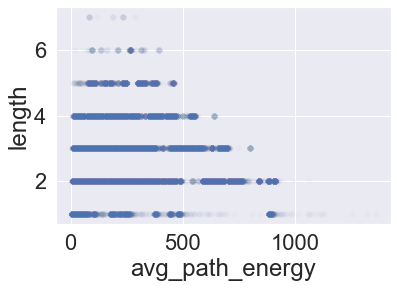

empirical_distplot_graph_param0_lengths_avg_path_energy_arenas-meta.png


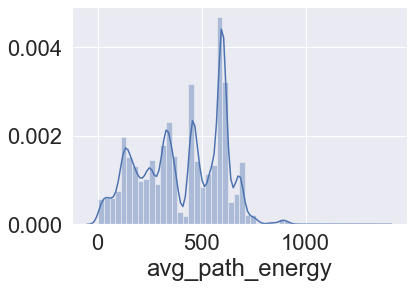

In [362]:
for _, (name, method) in empirical_corr.query("method == 'laplacian'").sort_values('abs_average_energy', ascending=False)\
                                  .loc[:, ['average_energy']].head(3).reset_index().loc[:,['name','method']].iterrows():
    draw_plots(emp_unified_paths_data_df, name, method, 'avg_path_energy')

In [368]:
table_begin = """\\begin{figure}[ht]
\centering"""

def subfigure(caption, label, file_name):
    return "\subfigure[" + caption + "]{\n"\
    +"  \label{fig:" + label + "}\n"\
    +"  \includegraphics[width=\myimagewidth]{figures/paths-correlations/" + file_name + "}\n"\
    +"}%"

table_end="""\caption{Scatter plots of shortest paths' lengths and average energies in the first row and distribution plots of shortest paths' average energies in the second row.}
\label{fig:lengts-avg_path_energy-scatterplots-distplots}
\end{figure}
"""

In [374]:
print(table_begin)
for _, (name, method) in empirical_corr.sort_values('abs_gradient', ascending=False)\
                                  .loc[:, ['gradient']].head(3).reset_index().loc[:,['name','method']].iterrows():
    print(subfigure(caption=f"{name.replace('_', ' ')}", 
                    label=f"{name}-scatter-gradients", 
                    file_name=f"{FILE_NAME_SCATTER_TEMPL.format('gradient', name)}"))
for _, (name, method) in empirical_corr.sort_values('abs_gradient', ascending=False)\
                                  .loc[:, ['gradient']].head(3).reset_index().loc[:,['name','method']].iterrows():                  
    print(subfigure(caption=f"{name.replace('_', ' ')}", 
                    label=f"{name}-scatter-gradients", 
                    file_name=f"{FILE_NAME_DIST_TEMPL.format('gradient', name)}"))
print(table_end)

\begin{figure}[ht]
\centering
\subfigure[moreno lesmis]{
  \label{fig:moreno_lesmis-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_scatter_graph_param0_lengths_gradient_moreno_lesmis.png}
}%
\subfigure[moreno train]{
  \label{fig:moreno_train-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_scatter_graph_param0_lengths_gradient_moreno_train.png}
}%
\subfigure[unicodelang]{
  \label{fig:unicodelang-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_scatter_graph_param0_lengths_gradient_unicodelang.png}
}%
\subfigure[moreno lesmis]{
  \label{fig:moreno_lesmis-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_distplot_graph_param0_lengths_gradient_moreno_lesmis.png}
}%
\subfigure[moreno train]{
  \label{fig:moreno_train-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/

In [373]:
print(table_begin)
for _, (name, method) in empirical_corr.query("method == 'laplacian'").sort_values('abs_average_energy', ascending=False)\
                                  .loc[:, ['average_energy']].head(3).reset_index().loc[:,['name','method']].iterrows():
    print(subfigure(caption=f"{name.replace('_', ' ')}", 
                    label=f"{name}-scatter-gradients", 
                    file_name=f"{FILE_NAME_SCATTER_TEMPL.format('avg_path_energy', name)}"))
for _, (name, method) in empirical_corr.query("method == 'laplacian'").sort_values('abs_average_energy', ascending=False)\
                                  .loc[:, ['average_energy']].head(3).reset_index().loc[:,['name','method']].iterrows():          
    print(subfigure(caption=f"{name.replace('_', ' ')}", 
                label=f"{name}-scatter-gradients", 
                file_name=f"{FILE_NAME_DIST_TEMPL.format('avg_path_energy', name)}"))
print(table_end)

\begin{figure}[ht]
\centering
\subfigure[brunson revolution]{
  \label{fig:brunson_revolution-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_scatter_graph_param0_lengths_avg_path_energy_brunson_revolution.png}
}%
\subfigure[maayan-foodweb]{
  \label{fig:maayan-foodweb-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_scatter_graph_param0_lengths_avg_path_energy_maayan-foodweb.png}
}%
\subfigure[arenas-meta]{
  \label{fig:arenas-meta-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_scatter_graph_param0_lengths_avg_path_energy_arenas-meta.png}
}%
\subfigure[brunson revolution]{
  \label{fig:brunson_revolution-scatter-gradients}
  \includegraphics[width=\myimagewidth]{figures/paths-correlations/empirical_distplot_graph_param0_lengths_avg_path_energy_brunson_revolution.png}
}%
\subfigure[maayan-foodweb]{
  \label{fig:maayan-foodweb-scatter-gradients}

In [375]:
g = nx.star_graph(10)

C:\Users\Tomi\Anaconda3\envs\entropy2\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


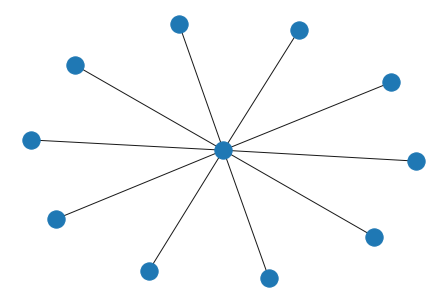

In [378]:
nx.draw(g)

C:\Users\Tomi\Anaconda3\envs\entropy2\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


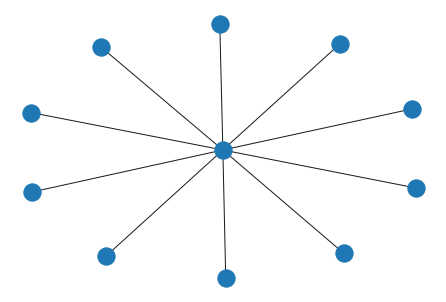

In [381]:
nx.draw(nx.ego_graph(g, 0))

In [383]:
g.add_edge(1, 2)

C:\Users\Tomi\Anaconda3\envs\entropy2\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


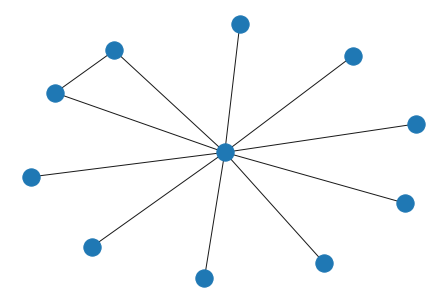

In [384]:
nx.draw(g)

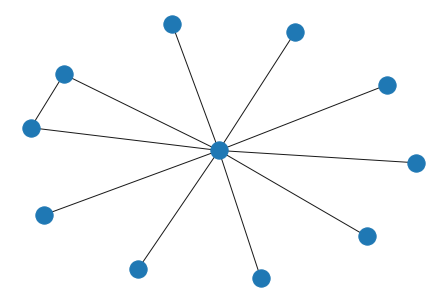

In [385]:
nx.draw(nx.ego_graph(g, 0))